## Downloads

In [1]:
!pip install preprocessor
!pip install vaderSentiment
!pip install torchmetrics
!pip install torch
!pip install transformers
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [2]:
import pandas as pd
import random
import json
import os
import preprocessor as p
import re
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import plotly.express as px
from sklearn.metrics import roc_curve, auc

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer, BertModel, BertConfig, BertForSequenceClassification
from transformers import RobertaConfig, RobertaModel, RobertaForSequenceClassification, RobertaTokenizer
from transformers import DebertaTokenizer, DebertaForSequenceClassification
from transformers import ElectraConfig, ElectraModel, ElectraTokenizer, ElectraForSequenceClassification

if torch.cuda.is_available():     
    device = torch.device("cuda")

nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Constants

In [3]:
dir_path = 'df_english_clean'
seed_val = 42
MODEL = 'ELECTRA' #'BERT', 'ELECTRA'

## Data Import 
See README for Instructions

In [4]:
df = pd.read_csv(dir_path)

In [5]:
df.head(10)

,text,withheld_in_countries,hashtags,lang,possibly_sensitive,verified_account,followers_count,location,user_id,withheld_anywhere,neg,neu,pos,compound,popularity_score
0,Pak Army is our pride,['IN'],['Balakot'],en,0.0,False,93,NaN,966615015716458497,1,0.000,0.789,0.211,0.3400,0.000542
1,"Ben Dunk ""If you haven't seen Lahore, you have...",['IN'],[],en,0.0,False,3525,NaN,1022545022447759360,1,0.000,1.000,0.000,0.0000,0.020472
2,India has also bestowed Abhinandan Varthaman w...,['IN'],['ہماراایمان_دفاع_پاکستان'],en,0.0,False,3746,United Arab Emirates,1178014718029651969,1,0.000,0.788,0.212,0.5423,0.013798
3,After the great Companion Saad bin Muadh embra...,['RU'],[],en,0.0,False,354,NaN,1043725274280538112,1,0.097,0.761,0.142,0.3182,0.001412
4,After the great Companion Saad bin Muadh embra...,['RU'],[],en,0.0,False,354,NaN,1043725274280538112,1,0.097,0.761,0.142,0.3182,0.001412
5,Paying homage to one of the great pilots in th...,['IN'],['Abhinandan'],en,0.0,False,411,Pakistan,1182959113929740296,1,0.052,0.545,0.403,0.9313,0.000790
6,Paying homage to one of the great pilots in th...,['IN'],['Abhinandan'],en,0.0,False,411,Pakistan,1182959113929740296,1,0.052,0.545,0.403,0.9313,0.000790
7,STRIP CHAT STRIP CHAT,['DE'],[],en,1.0,False,195344,NaN,148782077,1,0.000,1.000,0.000,0.0000,0.022920
8,Champions of Democracy are in fact champions o...,['IN'],[],en,0.0,False,1961,Pakistan,1322144832987537409,1,0.107,0.657,0.235,0.5719,0.001448
9,Militant commander Nooristan known as Hasan Ba...,['IN'],['SouthWaziristan'],en,0.0,False,1036,Pakistan,1270480467310055426,1,0.000,0.881,0.119,0.3182,0.003920


## Data Processing and Feature Encoding

In [6]:
df["withheld_anywhere"] = df["withheld_anywhere"].astype(int)
labels = np.array(df["withheld_anywhere"])

In [7]:
lemmatizer = WordNetLemmatizer()
def word_tokenize_wrapper(sentence): 
    if isinstance(sentence, str): 
        words = nltk.word_tokenize(sentence)
        tokens_without_sw = [word for word in words if not word in stopwords.words('english')]
        limitized_words = [lemmatizer.lemmatize(word) for word in tokens_without_sw]
        return tokens_without_sw
    else:
        return ''

text_tokenized_list = list(df.apply(lambda x: word_tokenize_wrapper(x['text']), axis=1))
cleaned_sentences = []
for sentences in text_tokenized_list:
    sentence = " ".join(sentences)
    cleaned_sentences.append(sentence)

## Model

In [8]:
%%capture
if MODEL == 'ROBERTA':
  tokenizer =  BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels = 2,  
    output_attentions = False,
    return_dict=False,
    output_hidden_states = False)
  
elif MODEL == 'ELECTRA': 
  configuration = ElectraConfig()
  model = ElectraModel(configuration)
  configuration = model.config
  tokenizer = ElectraTokenizer.from_pretrained("bhadresh-savani/electra-base-emotion")
  model = ElectraForSequenceClassification.from_pretrained("bhadresh-savani/electra-base-emotion", 
    num_labels = 2,  
    output_attentions = False,
    output_hidden_states = False, 
    return_dict=False,
    ignore_mismatched_sizes=True
)

else: 
  tokenizer =  BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2,  
    output_attentions = False,
    output_hidden_states = False, 
    return_dict=False
)
  
model.cuda()

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at bhadresh-savani/electra-base-emotion and are newly initialized because the shapes did not match:
- classifier.out_proj.weight: found shape torch.Size([6, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- classifier.out_proj.bias: found shape torch.Size([6]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
input_ids = []
attention_masks = []

max_length = 0
for tweet in cleaned_sentences:
    max_length = max(max_length, len(tweet))

for sentence in cleaned_sentences:
    encoded_dict = tokenizer.encode_plus(
                        sentence,                  
                        add_special_tokens = True, 
                        max_length = max_length,       
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,  
                        return_tensors = 'pt')

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print(input_ids.shape)
print(attention_masks.shape)
print(labels.shape)

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


torch.Size([25830, 156])
torch.Size([25830, 156])
torch.Size([25830])


In [10]:
### Hyperparameters
batch_size = 32
optimizer = AdamW(model.parameters(),lr = 2e-5, eps = 1e-8)
epochs = 6
division = 0.8

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [11]:
dataset = TensorDataset(input_ids, attention_masks, labels)
dataset_length = len(dataset)
train_size = int(division * dataset_length)
train_dataset, val_dataset = random_split(dataset, [train_size, (dataset_length - train_size)])
train_dataloader = DataLoader(train_dataset,  sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [12]:
y_pred = []
y_true = []
def keep_flat_labels(preds, labels): 
  y_pred.extend(np.argmax(preds, axis=1).flatten())
  y_true.extend(labels.flatten())

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [13]:
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
training_stats = []

for epoch_i in range(0, epochs):
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    tot_train_loss = 0
    model.train()
    for step, batch in enumerate(train_dataloader):
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        model.zero_grad()        
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        tot_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = tot_train_loss / len(train_dataloader)            
    print("\n Average training loss: {0:.2f}".format(avg_train_loss))
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        keep_flat_labels(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy
        }
    )

======== Epoch 1 / 6 ========

 Average training loss: 0.52
  Accuracy: 0.80
  Validation Loss: 0.44
======== Epoch 2 / 6 ========

 Average training loss: 0.41
  Accuracy: 0.84
  Validation Loss: 0.38
======== Epoch 3 / 6 ========

 Average training loss: 0.34
  Accuracy: 0.85
  Validation Loss: 0.37
======== Epoch 4 / 6 ========

 Average training loss: 0.29
  Accuracy: 0.85
  Validation Loss: 0.38
======== Epoch 5 / 6 ========

 Average training loss: 0.27
  Accuracy: 0.86
  Validation Loss: 0.37
======== Epoch 6 / 6 ========

 Average training loss: 0.25
  Accuracy: 0.86
  Validation Loss: 0.37


In [14]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats).set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.
epoch,,,
1,0.52,0.44,0.80
2,0.41,0.38,0.84
3,0.34,0.37,0.85
4,0.29,0.38,0.85
5,0.27,0.37,0.86
6,0.25,0.37,0.86


## Results Visualization

In [15]:
res = classification_report(y_true, y_pred, target_names=['Not Censord', 'Censord']) 
print(res)

              precision    recall  f1-score   support

 Not Censord       0.78      0.83      0.80     12048
     Censord       0.89      0.85      0.87     18948

    accuracy                           0.84     30996
   macro avg       0.83      0.84      0.83     30996
weighted avg       0.84      0.84      0.84     30996



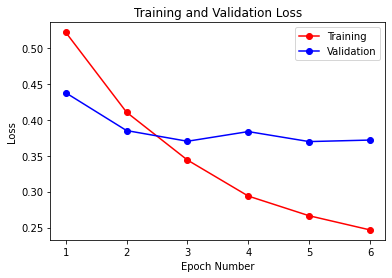

In [16]:
plt.plot(df_stats['Training Loss'], 'r-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'b-o', label="Validation")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.xticks([1, 2, 3, 4, 5, 6])
plt.legend()
plt.show()

In [17]:
#source: https://plotly.com/python/roc-and-pr-curves/
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()